In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
# define training and test data directories
data_dir = 'C:/Users/Dylan/Downloads/flowers/flowers'

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [5]:
# load and transform data using ImageFolder
    

data_transforms = transforms.Compose([transforms.Resize(224),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],
                                                                 [0.229, 0.224, 0.225])])

all_data = datasets.ImageFolder(data_dir, transform=data_transforms)

# Create test set using: sklearn.model_selection.train_test_split(random_state=1)
train_set, test_set = train_test_split(all_data, test_size=0.2, random_state=1)

# Creating data indices for training and validation splits:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(train_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size , num_workers=num_workers)


# print out some data stats
print('Num training images: ', len(train_sampler))
print('Num validation images: ', len(valid_sampler))
print('Num test images: ', len(test_set))

Num training images:  2767
Num validation images:  691
Num test images:  865


<ipython-input-6-a56dd8496b99>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

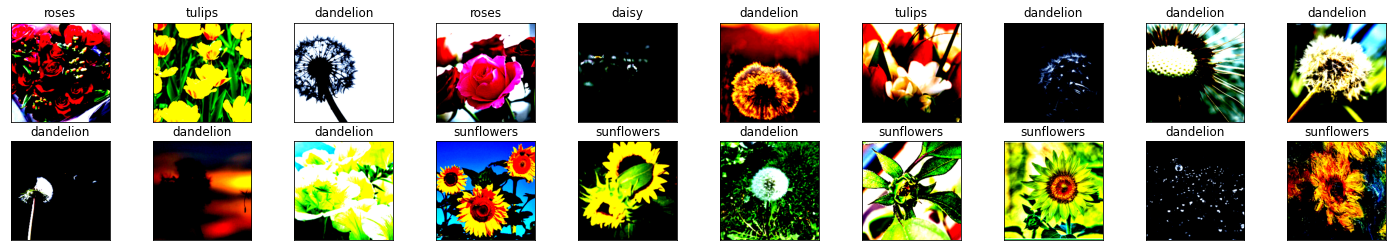

In [6]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert from Tensor images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes the color channel is the third dimension
    # we need to convert（channels,imagesize,imagesize）to（imagesize,imagesize,channels）, so plt.show() can show the image。
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [14]:
##### Create a CNN to Classify Flower Classification (from Scratch) #########
# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (inputs 224x224x3 image tensor) （width, heigh, depth ）
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) # in order to put the output layer the same size as the input image, choose
                                                    # padding = 1
        # convolutional layer (inputs 112x112x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (inputs 56x56x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (inputs 28x28x64 tensor)
        #self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (inputs 14x14x128 tensor)
        #self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        ##Batch normalization
        #self.batch_norm1 = nn.BatchNorm1d(num_features=2000)
        #self.batch_norm1 = nn.BatchNorm1d(num_features=500)
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2) # apply to it will downsample it's x, y dimensions by a factor of 2
        
        # linear layer (28 * 28 *64 -> 500) (depth, width, heigh)
        self.fc1 = nn.Linear(28 * 28 * 64, 500)
        
        # linear layer (500 -> 5)
        self.fc2 = nn.Linear(500, 5)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        # batch norm 
        self.batch_norm = nn.BatchNorm1d(num_features=500)
        
        
        # batch norm 
        ### Batch Norm has the effect of stabilizing the learning process and dramatically reducing the number
        ### of training epochs required to train deep networks.
        #self.batch_norm = nn.BatchNorm1d(num_features=500) # num_features – from an expected input of size (N, C, H, W)
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        
        # flatten image input, this will allow us to pass it as the input of the fully-connected layer
        x = x.view(-1, 28*28*64)
        #print(x.size())
        # add dropout layer
        x = self.dropout(x)
        # add 1st fully-connected layer, with a batch norm layer and relu activation function
        x = F.relu(self.batch_norm(self.fc1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd fully-connected layer
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [15]:
### Specify Loss Function and Optimizer ###

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01) # use SGD to get more accuracy
#optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.01) # use Adam to improve the training speed

# create dictionary for all loaders in one
loaders_scratch = {}
loaders_scratch['train'] = train_loader
loaders_scratch['valid'] = validation_loader
loaders_scratch['test'] = test_loader

In [16]:
### Train and Validate the Model ###
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders_scratch['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # calculate the batch loss
            loss = criterion_scratch(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item()*data.size(0)
            
            
        ######################    
        # validate the model #
        ######################    
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders_scratch['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_scratch(data)
            # calculate the batch loss
            loss = criterion_scratch(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            #valid_loss += loss.item()*data.size(0)
    

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss    
            
    # return trained model
    return model

# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 1.244045 	Validation Loss: 1.246099
Validation loss decreased (inf --> 1.246099).  Saving model ...
Epoch: 2 	Training Loss: 0.936542 	Validation Loss: 1.674452
Epoch: 3 	Training Loss: 0.683212 	Validation Loss: 1.734052
Epoch: 4 	Training Loss: 0.441827 	Validation Loss: 1.215626
Validation loss decreased (1.246099 --> 1.215626).  Saving model ...
Epoch: 5 	Training Loss: 0.238446 	Validation Loss: 1.415522
Epoch: 6 	Training Loss: 0.142376 	Validation Loss: 1.058153
Validation loss decreased (1.215626 --> 1.058153).  Saving model ...
Epoch: 7 	Training Loss: 0.087569 	Validation Loss: 1.038226
Validation loss decreased (1.058153 --> 1.038226).  Saving model ...
Epoch: 8 	Training Loss: 0.058099 	Validation Loss: 1.222058
Epoch: 9 	Training Loss: 0.038578 	Validation Loss: 1.072418
Epoch: 10 	Training Loss: 0.027195 	Validation Loss: 1.171553


<All keys matched successfully>

In [17]:
### Test the Model ###
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 1.121659


Test Accuracy (Overall): 60% (520/865)


<ipython-input-18-25ce348bf56c>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

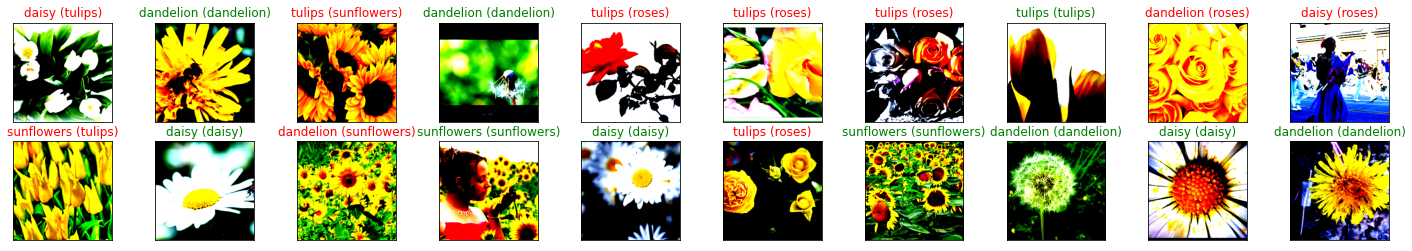

In [18]:
##### Visualize Sample Test Results #####
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_scratch(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))